In [103]:
import pickle
import h5py
from astropy.io import fits
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
simpars = ['\Omega_m','\sigma_8','log(A_{SN1})','log(A_{AGN1})','log(A_{SN2})','log(A_{AGN2})']
lims = [[0.1,0.5],[0.6,1.0],np.log([0.25,4.0]),np.log([0.25,4.0]),np.log([0.5,2.0]),np.log([0.5,2.0])]
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
plt.rc('font', family='Times New Roman')

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [3]:
xyz = [[1,2], [2,0], [0,1]]
mean_SFR_unfilt = np.array([])
mean_SFR = np.array([])
mean_SSFR = np.array([])
mean_e = np.array([])
std_e = np.array([])
mean_g_r = np.array([])

mean_SFR_ell = np.array([])
mean_SSFR_ell = np.array([])
mean_e_ell = np.array([])
std_e_ell = np.array([])
mean_g_r_ell = np.array([])

mean_SFR_spi = np.array([])
mean_SSFR_spi = np.array([])
mean_e_spi = np.array([])
std_e_spi = np.array([])
mean_g_r_spi = np.array([])

filt_g_r = np.array([])
all_g_r = np.array([])
all_SFR = np.array([])
all_M_R_12 = np.array([])
all_nstar = np.array([])

filt_SFR = np.array([])
filt_M_R_12 = np.array([])
filt_nstar = np.array([])
mean_SSFR = np.array([])
split_fracs = np.array([])
for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10
    nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
    photo_sh = f['Subhalo/SubhaloStellarPhotometrics'][:]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LH{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data
#     pos_sh = np.array([pos_sh[:,2],pos_sh[:,0],pos_sh[:,1]]).T
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T
#     print(pos_sh.shape, pos_g.shape)

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(pos_g[:2], pos_sh[:2])
#     print(filenum ," ",consistent)
    # filter out elliptical
    if consistent:
        g_r = (photo_sh[:,4] - photo_sh[:,5])
        filt_g_r = np.append(filt_g_r, g_r[indices])
        all_g_r = np.append(all_g_r, g_r)
#         print(len(SFR_sh[indices]))
#         print(sum(SFR_sh[indices]>0.1))
        all_SFR = np.append(all_SFR,SFR_sh)
        filt_SFR = np.append(filt_SFR,SFR_sh[indices])
        all_M_R_12 = np.append(all_M_R_12, subh_M_R_12)
        filt_M_R_12 = np.append(filt_M_R_12, subh_M_R_12[indices])
#         all_nstar = np.append(all_nstar, nstar_sh)
#         filt_nstar = np.append(filt_nstar, nstar_sh[indices])
#         all_gas = np.append(all_gas, ngas_sh)
#         filt_gas = np.append(filt_gas, ngas_sh[indices])
        mean_SFR = np.append(mean_SFR, np.mean(SFR_sh[indices]))
        mean_SFR_unfilt = np.append(mean_SFR_unfilt, np.mean(SFR_sh[subh_M_R_12>1e10]))
        mean_SSFR = np.append(mean_SSFR, np.mean(SFR_sh[indices]/subh_M_R_12[indices]))
        e = np.sqrt(ias[:,0]**2+ias[:,0]**2)
        mean_e = np.append(mean_e, np.mean(e))
        std_e = np.append(std_e, np.std(e))
        mean_g_r = np.append(mean_g_r, np.mean((g_r[indices])))
        
        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = subh_M_R_12[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        print(filenum,len(pos_g[spiral]),len(pos_g[elliptical]))
        # fraction of reds vs blues
        split_fracs = np.append(split_fracs, len(pos_g[elliptical])/len(pos_g[spiral]))
        
        
        mean_SFR_ell = np.append(mean_SFR_ell, np.mean((SFR_sh[indices])[elliptical]))
        mean_SSFR_ell = np.append(mean_SSFR_ell, np.mean((SFR_sh[indices]/subh_M_R_12[indices])[elliptical]))
        mean_e_ell = np.append(mean_e_ell, np.mean(e[elliptical]))
        std_e_ell = np.append(std_e_ell, np.std(e[elliptical]))
        mean_g_r_ell = np.append(mean_g_r_ell, np.mean((g_r[indices])[elliptical]))
        
        mean_SFR_spi = np.append(mean_SFR_spi, np.mean((SFR_sh[indices])[spiral]))
        mean_SSFR_spi = np.append(mean_SSFR_spi, np.mean((SFR_sh[indices]/subh_M_R_12[indices])[spiral]))
        mean_e_spi = np.append(mean_e_spi, np.mean(e[spiral]))
        std_e_spi = np.append(std_e_spi, np.std(e[spiral]))
        mean_g_r_spi = np.append(mean_g_r_spi, np.mean((g_r[indices])[spiral]))
        
    else:
        print('Not consistent')


0 290 119
1 218 130
2 381 789
3 309 40
4 284 74
5 336 147
6 274 243
7 421 276
8 464 1323
9 778 740
10 368 1164
11 109 275
12 251 370
13 560 738
14 297 79
15 486 186
16 277 120
17 127 11
18 213 29
19 505 278
20 657 480
21 648 1027
22 463 195
23 337 148
24 651 313
25 285 97
26 338 316
27 578 280
28 690 1100
29 509 212
30 249 103
31 103 312
32 526 1113
33 281 76
34 239 514
35 584 607
36 468 229
37 215 294
38 311 172
39 213 67
40 165 90
41 393 1007
42 349 150
43 120 21
44 315 71
45 240 82
46 380 328
47 644 393
48 499 798
49 472 357
50 641 622
51 188 30
52 179 99
53 591 312
54 681 245
55 667 273
56 394 89
57 206 49
58 221 109
59 415 1306
60 383 389
61 398 312
62 812 409
63 718 400
64 220 75
65 451 1045
66 512 1104
67 693 526
68 320 113
69 538 580
70 338 1055
71 325 428
72 573 480
73 486 326
74 352 166
75 517 270
76 596 427
77 453 224
78 351 142
79 499 894
80 206 76
81 589 492
82 259 70
83 472 250
84 906 336
85 518 314
86 383 131
87 354 92
88 666 385
89 268 116
90 382 182
91 213 157
92 556 3

700 559 233
701 303 166
702 463 343
703 599 422
704 538 435
705 311 510
706 419 80
707 420 875
708 299 235
709 556 302
710 468 265
711 707 616
712 242 62
713 196 21
714 915 455
715 722 156
716 243 125
717 742 468
718 268 64
719 106 41
720 348 312
721 702 344
722 462 163
723 464 601
724 363 306
725 389 135
726 392 98
727 376 269
728 345 99
729 414 109
730 283 136
731 725 576
732 486 214
733 246 106
734 172 122
735 214 388
736 647 422
737 277 142
738 136 106
739 209 7
740 619 752
741 233 294
742 694 346
743 240 53
744 447 195
745 720 863
746 198 256
747 190 42
748 622 469
749 429 90
750 281 158
751 211 60
752 338 525
753 450 265
754 505 1264
755 262 217
756 267 68
757 635 620
758 839 501
759 409 127
760 558 231
761 289 69
762 328 123
763 321 76
764 343 83
765 195 401
766 433 243
767 343 84
768 404 279
769 785 423
770 447 197
771 811 740
772 463 1047
773 172 149
774 489 542
775 495 69
776 155 57
777 201 164
778 731 475
779 295 235
780 732 520
781 460 725
782 289 46
783 354 346
784 876 400

In [69]:
print(len(SFR_sh), len(SFR_sh[nstar_sh>10]), len(SFR_sh[subh_M_R_12>1e10]), len(SFR_sh[(subh_M_R_12>1e8)&(nstar_sh>10)]))

20505 804 66 756


In [37]:
# save properties of galaxies
data = np.column_stack((mean_SFR, mean_SSFR, mean_e, std_e, split_fracs))

# Save to a text file
np.savetxt(
    "../sim_galaxyProperties.txt", 
    data, 
    fmt="%.6e",  # Format: scientific notation with 6 decimal places
    header="mean_SFR mean_SSFR mean_e std_e split_fracs",  # Column names
    comments=""  # Removes the '#' at the beginning of the header
)


In [6]:
label_table = np.loadtxt("../test-dependence-folder/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt", skiprows=1, usecols=range(1, 7))
for i in range(label_table.shape[1]):
    if i>1:
        label_table[:,i] = np.log(label_table[:,i])
print(mean_SFR.shape, label_table.shape)

(1000,) (1000, 6)


In [89]:
# SAVING PEARSON VALUES
pearsons_SSFR = -np.ones((3,6))
p_vals_SSFR = -np.ones((3,6))
pearsons_e = -np.ones((3,6))
p_vals_e = -np.ones((3,6))

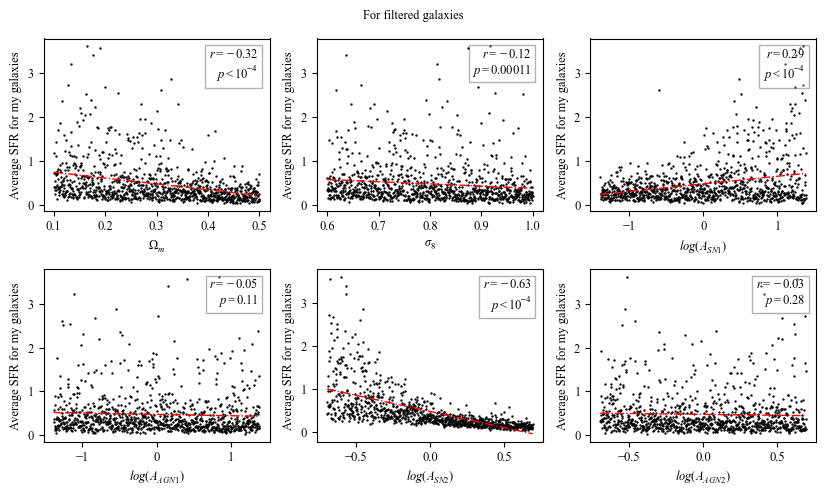

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
fig.suptitle('For filtered galaxies')
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SFR, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SFR)
    

    ax.scatter(label_table[:,param], mean_SFR, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for my galaxies')
    
plt.tight_layout()
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/avg SFR vs params.pdf', dpi=300)
plt.show()

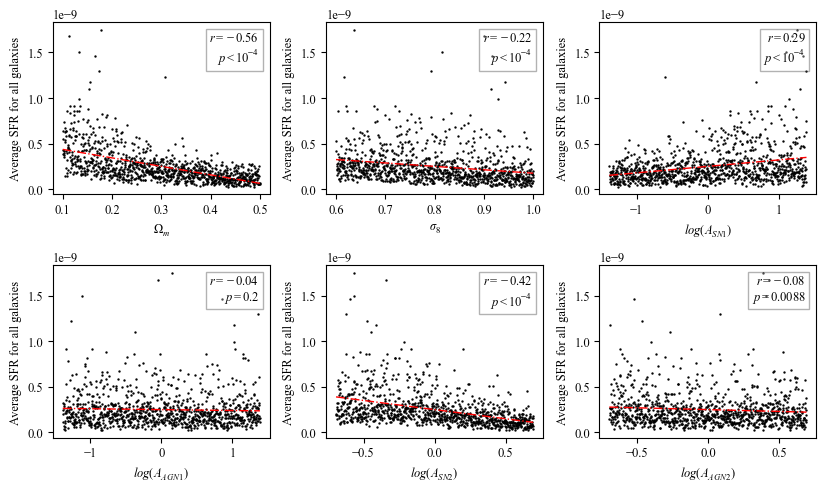

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR)
    

    ax.scatter(label_table[:,param], mean_SSFR, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[0,i] = pearson_coeff; p_vals_SSFR[0,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

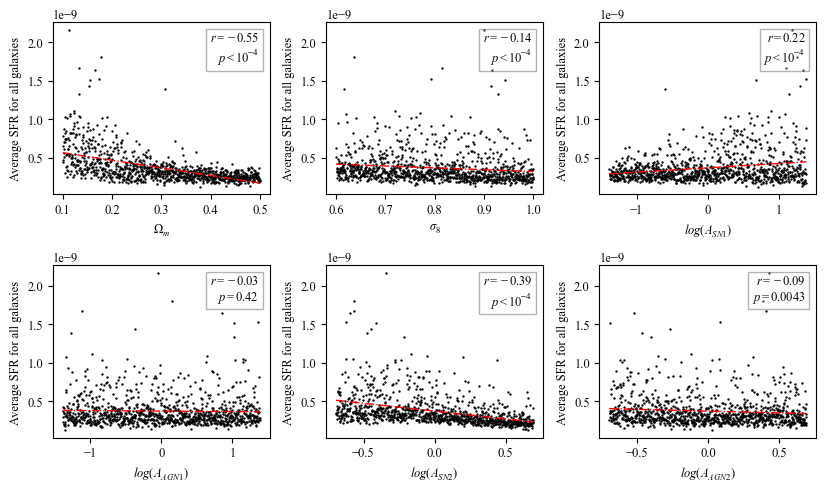

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR_spi, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR_spi)
    

    ax.scatter(label_table[:,param], mean_SSFR_spi, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[1,i] = pearson_coeff; p_vals_SSFR[1,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

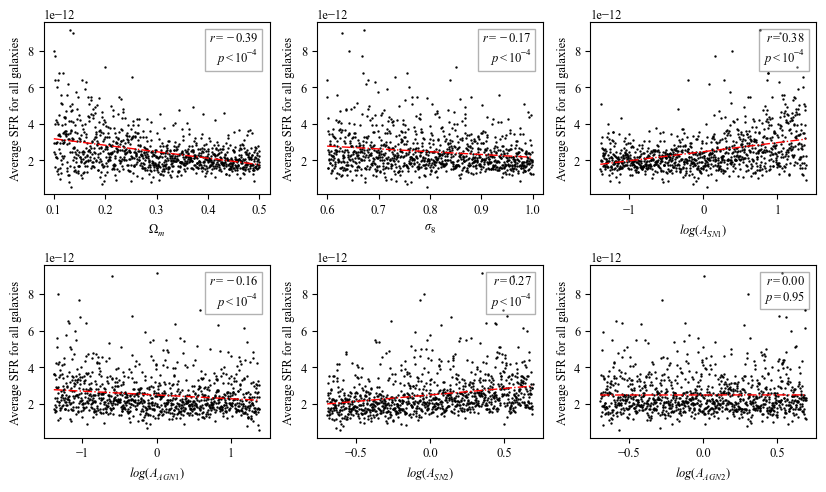

In [149]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_SSFR_ell, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_SSFR_ell)
    

    ax.scatter(label_table[:,param], mean_SSFR_ell, c='k', s=0.5)
    
    if p_value>1e-4:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_SSFR[2,i] = pearson_coeff; p_vals_SSFR[2,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average SFR for all galaxies')
    
plt.tight_layout()

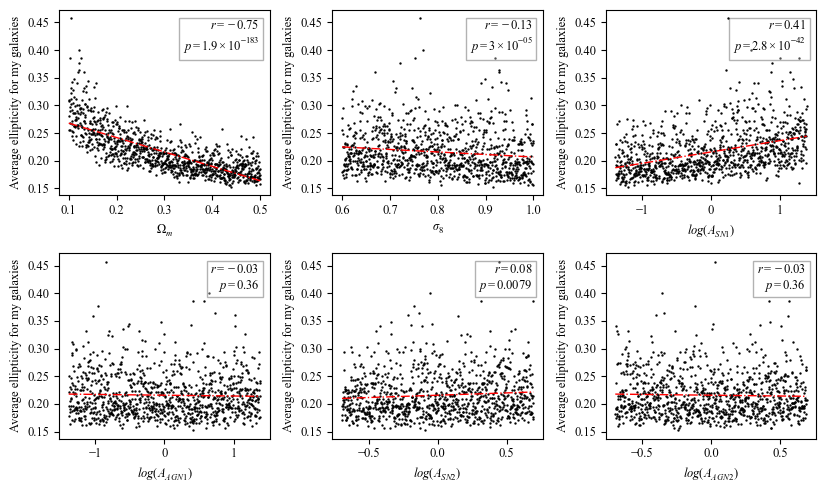

In [93]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e)
    

    ax.scatter(label_table[:,param], mean_e, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[0,i] = pearson_coeff; p_vals_e[0,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my galaxies')
    
plt.tight_layout()

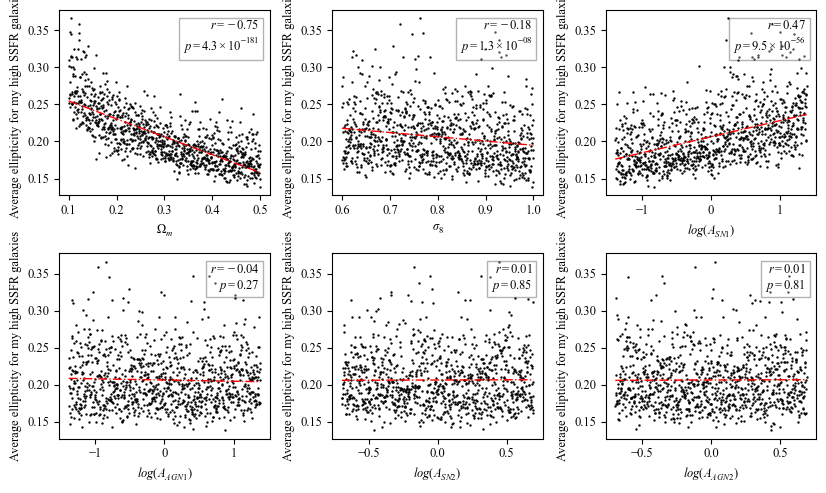

In [94]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e_spi, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e_spi)
    

    ax.scatter(label_table[:,param], mean_e_spi, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[1,i] = pearson_coeff; p_vals_e[1,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my high SSFR galaxies')
    
plt.tight_layout()

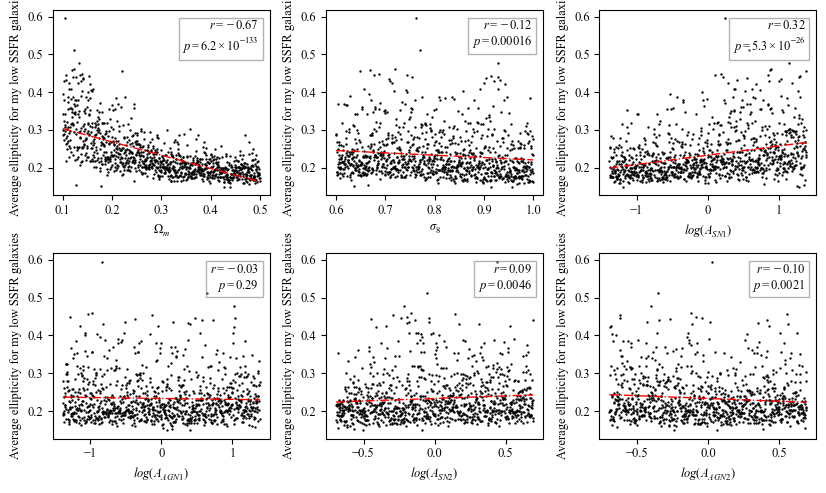

In [95]:
fig, axes = plt.subplots(2, 3, figsize=(25/3, 5))
axes = axes.flatten()
for i, param in enumerate(range(6)):
    ax = axes[i]
    
    slope, intercept = np.polyfit(label_table[:,param], mean_e_ell, 1)
    x_vals = np.linspace(min(lims[param]), max(lims[param]), 10)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")
    
    pearson_coeff, p_value = pearsonr(label_table[:,param], mean_e_ell)
    

    ax.scatter(label_table[:,param], mean_e_ell, c='k', s=0.5)
    
    if p_value:
        ax.text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    else:
        ax.text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
    pearsons_e[2,i] = pearson_coeff; p_vals_e[2,i] = p_value
    ax.set_xlabel(f'${simpars[param]}$')
    ax.set_ylabel(f'Average ellipticity for my low SSFR galaxies')
    
plt.tight_layout()

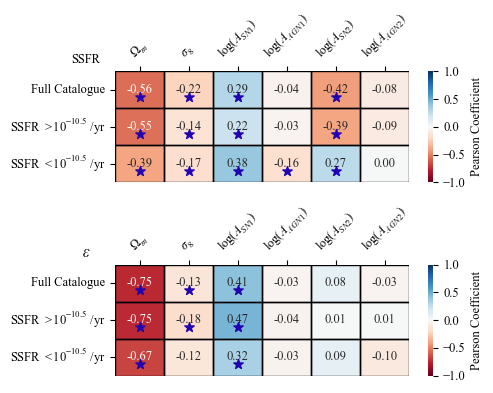

In [151]:
catalogues = ['Full Catalogue', 'SSFR $>10^{-10.5}$ /yr', 'SSFR $<10^{-10.5}$ /yr']
simpars_ = [r'$\Omega_m$', r'$\sigma_8$', r'$\log(A_{SN1})$', r'$\log(A_{AGN1})$', r'$\log(A_{SN2})$', r'$\log(A_{AGN2})$']
significance_mask = p_vals_SSFR < 1e-4
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(5, 4))
sns.heatmap(
    pearsons_SSFR, 
    annot=True,  
    fmt=".2f", 
    cmap="RdBu",  
    vmin=-1, vmax=1,  
    yticklabels=catalogues, 
    xticklabels=simpars_, ax=ax[0],
    cbar_kws={'label': 'Pearson Coefficient'}  
)
for y in range(pearsons_SSFR.shape[0]):  
    for x in range(pearsons_SSFR.shape[1]):  # Loop over columns
        if significance_mask[y, x]:  # Check if p-value is significant
            ax[0].scatter(x + 0.5, y + 0.7, color='xkcd:ultramarine', marker='*',s=50, zorder=10)
        ax[0].add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='xkcd:black', lw=1))  # Add border
ax[0].xaxis.set_ticks_position('top')
ax[0].xaxis.set_label_position('top')
ax[0].tick_params(axis='x', rotation=45)
ax[0].text(-0.1, 1.1, 'SSFR', fontsize=9, ha='center', va='center', transform=ax[0].transAxes)
significance_mask = p_vals_e < 1e-4
sns.heatmap(
    pearsons_e, 
    annot=True,  
    fmt=".2f", 
    cmap="RdBu",  
    vmin=-1, vmax=1,  
    yticklabels=catalogues, 
    xticklabels=simpars_, ax=ax[1],
    cbar_kws={'label': 'Pearson Coefficient'}  
)
for y in range(pearsons_e.shape[0]):  
    for x in range(pearsons_e.shape[1]):  # Loop over columns
        if significance_mask[y, x]:  # Check if p-value is significant
            ax[1].scatter(x + 0.5, y + 0.7, color='xkcd:ultramarine', marker='*',s=50, zorder=10)
        ax[1].add_patch(plt.Rectangle((x, y), 1, 1, fill=False, edgecolor='xkcd:black', lw=1))  # Add bord

    
ax[1].xaxis.set_ticks_position('top')
ax[1].xaxis.set_label_position('top')
ax[1].tick_params(axis='x', rotation=45)
ax[1].text(-0.1, 1.1, '$\epsilon$', fontsize=12, fontweight='bold', ha='center', va='center', transform=ax[1].transAxes)


plt.tight_layout()
plt.savefig(
    '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/SSFR e table.pdf',
    dpi=300, bbox_inches='tight')
plt.show()

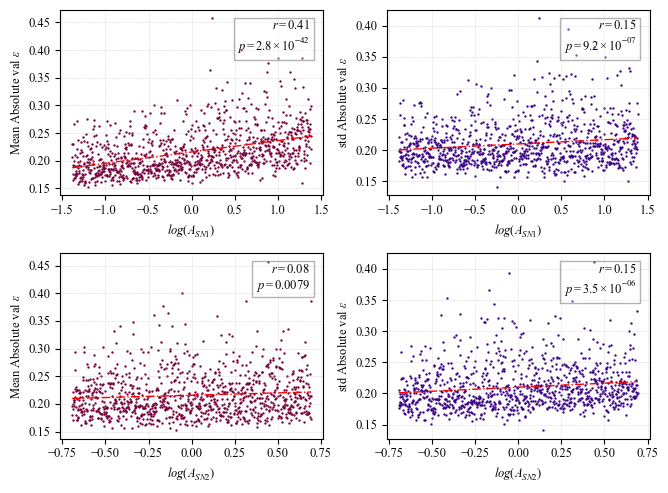

In [92]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20/3,5))
axes = ax.flatten()
for axis in axes:
    axis.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)
      
axes[0].scatter(label_table[:,2], mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(label_table[:,2], mean_e, 1)
x_vals = np.linspace(min(lims[2]), max(lims[2]), 10)
y_vals = slope * x_vals + intercept
axes[0].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,2], mean_e)
if p_value:
    axes[0].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[0].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[0].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))
axes[0].set_xlabel(f'${simpars[2]}$')
axes[0].set_ylabel(r'Mean Absolute val $\epsilon$')
axes[1].scatter(label_table[:,2], std_e, c='xkcd:indigo', s=0.5)
slope, intercept = np.polyfit(label_table[:,2], std_e, 1)
x_vals = np.linspace(min(lims[2]), max(lims[2]), 10)
y_vals = slope * x_vals + intercept
axes[1].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,2], std_e)
if p_value:
    axes[1].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[1].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[1].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[1].set_ylabel(r'std Absolute val $\epsilon$')
axes[1].set_xlabel(f'${simpars[2]}$')
axes[2].scatter(label_table[:,4], mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(label_table[:,4], mean_e, 1)
x_vals = np.linspace(min(lims[4]), max(lims[4]), 10)
y_vals = slope * x_vals + intercept
axes[2].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,4], mean_e)
if p_value:
    axes[2].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[2].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[2].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[2].set_ylabel(r'Mean Absolute val $\epsilon$')
axes[2].set_xlabel(f'${simpars[4]}$')
axes[3].scatter(label_table[:,4], std_e, c='xkcd:indigo', s=0.5)
slope, intercept = np.polyfit(label_table[:,4], std_e, 1)
x_vals = np.linspace(min(lims[4]), max(lims[4]), 10)
y_vals = slope * x_vals + intercept
axes[3].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(label_table[:,4], std_e)
if p_value:
    axes[3].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=axes[3].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
else:
    axes[3].text(0.95, 0.95, f"$r={pearson_coeff:.2f}$\n"+r'$p<10^{-4}$', transform=axes[3].transAxes, 
    fontsize=9, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="square", edgecolor='black',facecolor='white', alpha=0.3))

axes[3].set_ylabel(r'std Absolute val $\epsilon$')
axes[3].set_xlabel(f'${simpars[4]}$')
plt.tight_layout()
plt.savefig('/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/ell vs params.pdf', dpi=300)
plt.show()

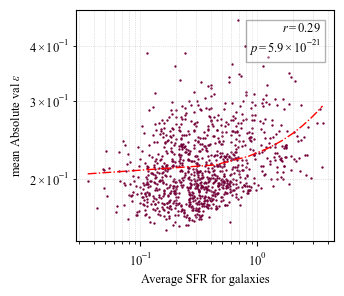

In [243]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(mean_SFR, mean_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(mean_SFR, mean_e, 1)
x_vals = np.linspace(min(mean_SFR), max(mean_SFR), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SFR, mean_e)
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_ylabel(r'mean Absolute val $\epsilon$')
ax.set_xlabel(f'Average SFR for galaxies')
# ax.set_xscale('log')
# ax.set_yscale('log')

/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_75631/2899397941.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


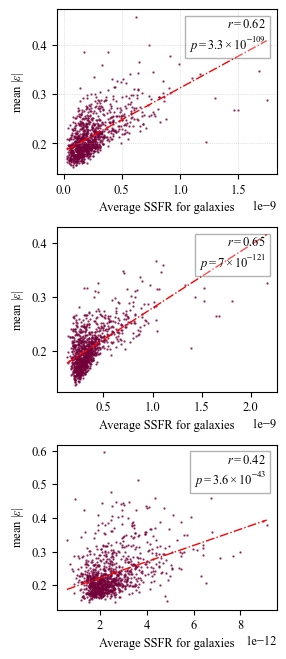

In [168]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(3,20/3))
ax[0].grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax[0].scatter(mean_SSFR, mean_e, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR, mean_e, 1)
x_vals = np.linspace(min(mean_SSFR), max(mean_SSFR), 100)
y_vals = slope * x_vals + intercept
ax[0].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR, mean_e)
if p_value:
    ax[0].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[0].set_ylabel(r'mean $|\epsilon|$')
ax[0].set_xlabel(f'Average SSFR for galaxies')

ax[1].scatter(mean_SSFR_spi, mean_e_spi, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR_spi, mean_e_spi, 1)
x_vals = np.linspace(min(mean_SSFR_spi), max(mean_SSFR_spi), 100)
y_vals = slope * x_vals + intercept
ax[1].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR_spi, mean_e_spi)
if p_value:
    ax[1].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[1].set_ylabel(r'mean $|\epsilon|$')
ax[1].set_xlabel(f'Average SSFR for galaxies')

ax[2].scatter(mean_SSFR_ell, mean_e_ell, c='xkcd:merlot', s=0.5,alpha=0.7)
slope, intercept = np.polyfit(mean_SSFR_ell, mean_e_ell, 1)
x_vals = np.linspace(min(mean_SSFR_ell), max(mean_SSFR_ell), 100)
y_vals = slope * x_vals + intercept
ax[2].plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(mean_SSFR_ell, mean_e_ell)
if p_value:
    ax[2].text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
ax[2].set_ylabel(r'mean $|\epsilon|$')
ax[2].set_xlabel(f'Average SSFR for galaxies')
plt.tight_layout( h_pad=-1, w_pad=None, rect=None)
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig(
    '/Users/danie/Library/CloudStorage/OneDrive-Personal/Physics UCL/Year 3/Astro Research Project 2023/mean SSFR vs mean e.pdf',
    dpi=300)

Text(0.5, 0, 'Average log(SFR) for galaxies')

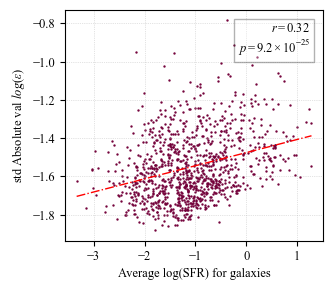

In [169]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(np.log(mean_SFR), np.log(mean_e), c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(np.log(mean_SFR), np.log(mean_e), 1)
x_vals = np.linspace(min(np.log(mean_SFR)), max(np.log(mean_SFR)), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(np.log(mean_SFR), np.log(mean_e))
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_ylabel(r'mean Absolute val $log(\epsilon)$')
ax.set_xlabel(f'Average log(SFR) for galaxies')

#### Rescaling ellipticities to account for SFR

Text(0.5, 0, 'Average SFR for galaxies')

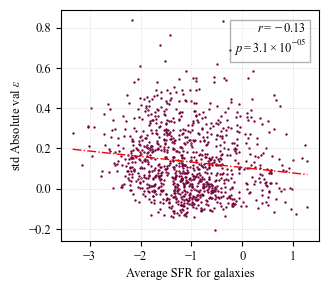

In [174]:
weighted_e = np.log(mean_e) - (slope * np.log(mean_SFR) + intercept)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
ax.grid(which='both', linestyle='dotted', linewidth=0.5, alpha=0.7)

ax.scatter(np.log(mean_SFR), weighted_e, c='xkcd:merlot', s=0.5)
slope, intercept = np.polyfit(np.log(mean_SFR), weighted_e, 1)
x_vals = np.linspace(min(np.log(mean_SFR)), max(np.log(mean_SFR)), 10)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, lw=1, color='red', linestyle='-.', label=f"Linear Fit")

pearson_coeff, p_value = pearsonr(np.log(mean_SFR), weighted_e)
if p_value:
    ax.text( 0.95, 0.95, 
    f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
    transform=ax.transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    
    
ax.set_ylabel(r'mean log Absolute val $\epsilon$')
ax.set_xlabel(f'Average log(SFR) for galaxies')
# ax.set_xscale('log')
# ax.set_yscale('log')

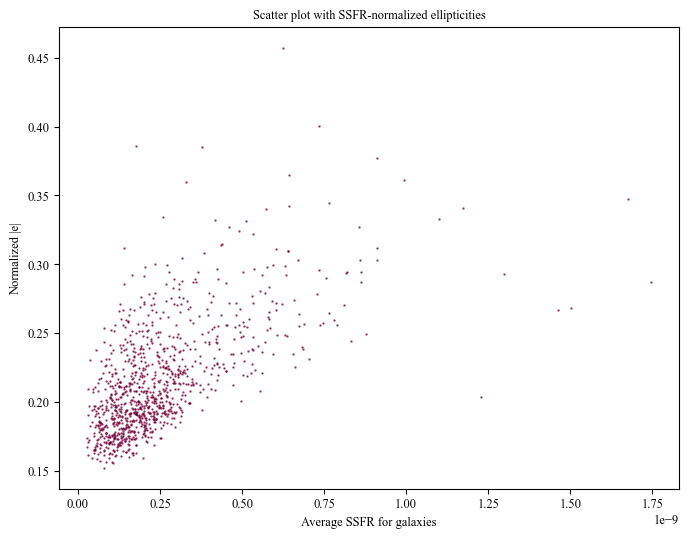

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Fit a LOESS curve to the data
ssfr_sorted = np.sort(mean_SSFR)
ell_sorted = mean_e[np.argsort(mean_SSFR)]
loess_fit = interp1d(ssfr_sorted, ell_sorted, kind='cubic')

# Evaluate the LOESS fit at the original SSFR values
ell_predicted = loess_fit(mean_SSFR)

# Subtract the LOESS fit from the original ellipticities to get the normalized values
normalized_e = mean_e - ell_predicted

# Create the scatter plot with the normalized ellipticities
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(mean_SSFR, ell_predicted, c='xkcd:merlot', s=0.5, alpha=0.7)
ax.set_xlabel('Average SSFR for galaxies')
ax.set_ylabel('Normalized |e|')
ax.set_title('Scatter plot with SSFR-normalized ellipticities')
plt.show()

In [171]:
normalized_e

array([0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574745,
       0.21574745, 0.21574745, 0.21574745, 0.21574745, 0.21574

In [ ]:
SF = np.where(filt_SFR!=0)[0]
print(len(SF)/len(filt_SFR))
NSF = np.where(filt_SFR==0)[0]

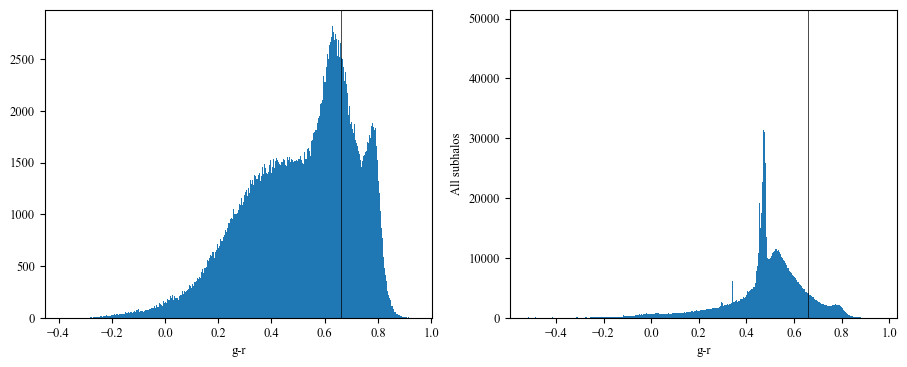

In [209]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
ax[0].hist(filt_g_r,bins=1000)
ax[0].axvline(0.66,c='k',lw=0.5)
ax[0].set_xlabel('g-r')
ax[1].hist(all_g_r[all_g_r!=0],bins=1000)
ax[1].axvline(0.66,c='k',lw=0.5)
ax[1].set_xlabel('g-r')
ax[1].set_ylabel('All subhalos')
# ax[0].set_xscale('log')
plt.show()

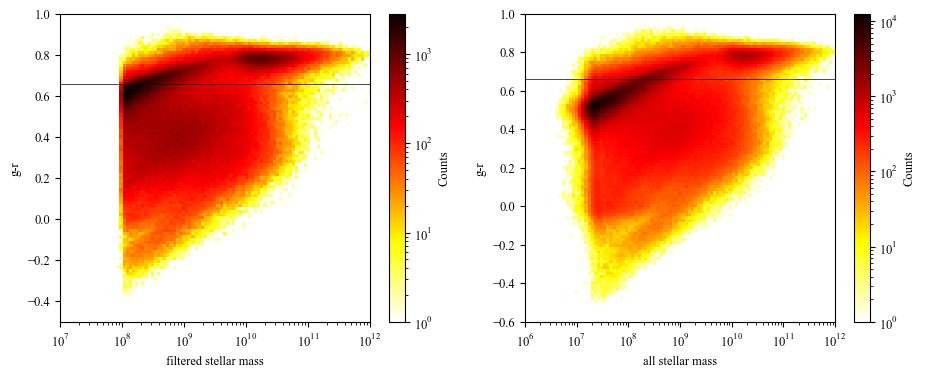

In [295]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# ax[0].scatter(filt_M_R_12, filt_g_r, s=0.01)
h = ax[0].hist2d(filt_M_R_12, filt_g_r, bins=(np.logspace(7,12,100),np.linspace(-0.5,1,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
ax[0].axhline(0.66,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_ylabel('g-r')
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(all_M_R_12, all_g_r, bins=(np.logspace(6,12,100),np.linspace(-0.6,1,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(0.66,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_ylabel('g-r')
ax[1].set_xlabel('all stellar mass')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")


0.38336608856415555

In [24]:
print(np.mean(filt_g_r))

0.5120813766017127


-10.5

/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_27755/3515463947.py:18: RuntimeWarning: divide by zero encountered in divide
  h = ax[1].hist2d(all_M_R_12, all_SFR/all_M_R_12, bins=(np.logspace(7,12,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
/var/folders/2k/4lvm79j14sg5_v8dqx8tly7h0000gn/T/ipykernel_27755/3515463947.py:18: RuntimeWarning: invalid value encountered in divide
  h = ax[1].hist2d(all_M_R_12, all_SFR/all_M_R_12, bins=(np.logspace(7,12,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')


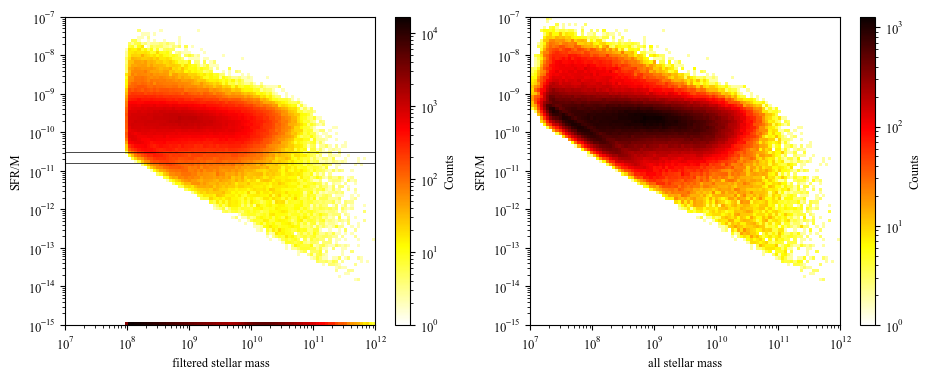

In [11]:
import matplotlib as mpl
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# Avoid division by zero by replacing zeros with a small positive value
epsilon = 1e-15
sfr_to_mass = np.where(filt_SFR / filt_M_R_12 > 0, filt_SFR / filt_M_R_12, epsilon)


h = ax[0].hist2d(filt_M_R_12, sfr_to_mass, bins=(np.logspace(7,12,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('SFR/M')
ax[0].axhline(10**-10.5,c='k',lw=0.5)
ax[0].axhline(10**-10.8,c='k',lw=0.5)
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(all_M_R_12, all_SFR/all_M_R_12, bins=(np.logspace(7,12,100), np.logspace(-15,-7,100)), norm=mpl.colors.LogNorm(), cmap='hot_r')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(0.66,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('SFR/M')
ax[1].set_xlabel('all stellar mass')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")

#### Split informaition

In [33]:
print("fraction of SSR=0 galaxies: - no gas left", sum((filt_SFR/filt_M_R_12)==0)/len(filt_SFR/filt_M_R_12))
print("fraction of galaxies with SSFR<10^{-10.5} - red galaxies", sum((filt_SFR/filt_M_R_12)<10**-10.5)/len(filt_SFR))
print(np.mean(split_fracs))
print(np.mean(mean_SFR), np.mean(mean_SFR_ell), np.mean(mean_SFR_spi))
print(np.mean(mean_SSFR), np.mean(mean_SSFR_ell), np.mean(mean_SSFR_spi))
print(np.mean(mean_g_r), np.mean(mean_g_r_ell), np.mean(mean_g_r_spi))
print(np.mean(mean_e), np.mean(mean_e_ell), np.mean(mean_e_spi))
print(np.mean(std_e), np.mean(std_e_ell), np.mean(std_e_spi))

fraction of SSR=0 galaxies: - no gas left 0.38336608856415555
fraction of galaxies with SSFR<10^{-10.5} - red galaxies 0.44115044301500267
0.7916880246664596
0.47740096897631884 0.031831552084186115 0.6897309661656618
2.502211841805962e-10 2.479577482304273e-12 3.7152245269123086e-10
0.47744701911509035 0.6472191713750363 0.37721340024471284
0.21574744640381852 0.23327656437757074 0.20639063623452406
0.20994518871884135 0.24943453234686905 0.17844246458965882


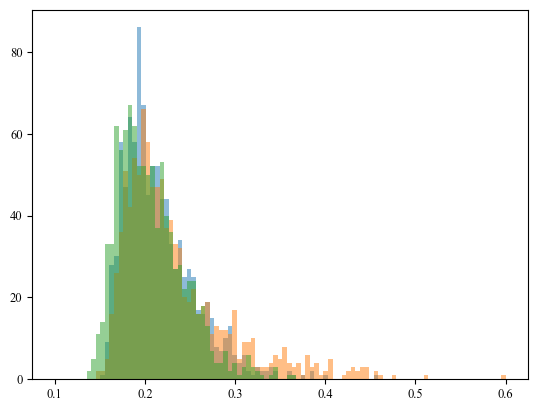

In [36]:
plt.hist(mean_e, bins=np.linspace(0.1,0.6,100),alpha=0.5)
plt.hist(mean_e_ell, bins=np.linspace(0.1,0.6,100),alpha=0.5)
plt.hist(mean_e_spi, bins=np.linspace(0.1,0.6,100),alpha=0.5)
plt.show()

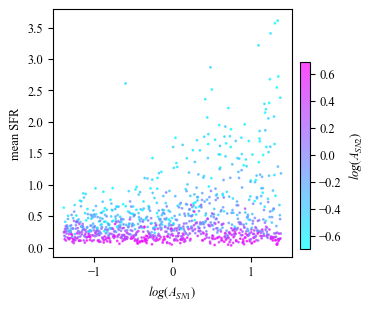

In [115]:
import matplotlib as mpl
param=2
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
h = ax.scatter(label_table[:,param], mean_SFR, s=1, c=label_table[:,4], cmap=mpl.cm.cool,alpha=0.7,label="")
ax.set_xlabel(f'${simpars[param]}$')
ax.set_ylabel(f'mean SFR')
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('$log(A_{SN2})$', fontsize=9)
fig.set_constrained_layout(True)

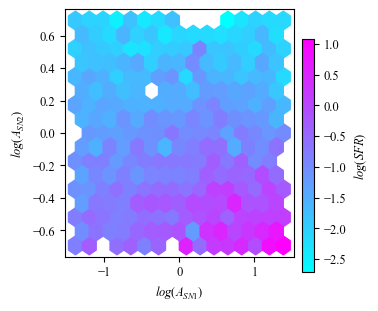

In [155]:
fig, ax = plt.subplots(figsize=(10/3, 3))
hb = ax.hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_SFR), 
    gridsize=15,  # Adjust the resolution of the bins
    cmap=mpl.cm.cool, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax.set_xlabel(f'${simpars[2]}$')
ax.set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('$log(SFR)$', fontsize=9)
fig.set_constrained_layout(True)


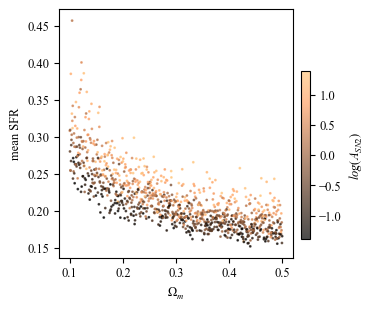

In [163]:
param=0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10/3,3))
scatter = ax.scatter(label_table[:,param], mean_e, s=1, c=label_table[:,2], cmap=mpl.cm.copper,alpha=0.7,label="")
ax.set_xlabel(f'${simpars[param]}$')
ax.set_ylabel(f'mean ellipticity')
cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.8, pad=0.02)
cbar.set_label('$log(A_{SN1})$', fontsize=9)
fig.set_constrained_layout(True)

NameError: name 'mpl' is not defined

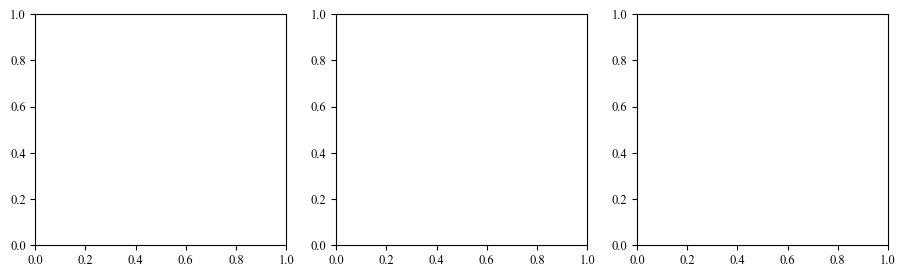

In [101]:
param=0
def plotCB(param,y1,y2,y3,c1,c2,c3,ylabel=f'SSFR /yr',clabel=r'$log(\langle\epsilon\rangle)$'):
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(33/3,3))
    scatter = ax[0].scatter(label_table[:,param], y1, s=5, c=c1, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[0].set_xlabel(f'${simpars[param]}$')
    ax[0].set_ylabel(ylabel)
    cbar = fig.colorbar(scatter, ax=ax[0], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(clabel, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y1)
    if p_value:
        ax[0].text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[0].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    scatter = ax[1].scatter(label_table[:,param], y2, s=5, c=c2, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[1].set_xlabel(f'${simpars[param]}$')
    ax[1].set_ylabel(ylabel)
    cbar = fig.colorbar(scatter, ax=ax[1], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(clabel, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y2)
    if p_value:
        ax[1].text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[1].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    scatter = ax[2].scatter(label_table[:,param], y3, s=5, c=c3, cmap=mpl.cm.cool,alpha=0.7,label="")
    ax[2].set_xlabel(f'${simpars[param]}$')
    ax[2].set_ylabel(ylabel)
    cbar = fig.colorbar(scatter, ax=ax[2], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(clabel, fontsize=9)
    pearson_coeff, p_value = pearsonr(label_table[:,param], y3)
    if p_value:
        ax[2].text( 0.95, 0.95, 
        f"$r={pearson_coeff:.2f}$\n$p={p_value:.2g}".replace('e', r'\times10^{').replace('-', r'-') + "}$",
        transform=ax[2].transAxes, fontsize=9, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle="square", edgecolor='black', facecolor='white', alpha=0.3))
    plt.tight_layout()
plotCB(0, mean_e, mean_e_spi, mean_e_ell, label_table[:,2], label_table[:,2], label_table[:,2], 
       ylabel=f'mean ellipticity', clabel=r'$A_{SN1}$')

In [221]:
print(np.mean(mean_e), np.mean(mean_e_spi), np.mean(mean_e_ell))
print(np.std(mean_e), np.std(mean_e_spi), np.std(mean_e_ell))

0.21574744640381852 0.13862997770667057 0.5952280881469957
0.03995074236174389 0.03719506362848142 0.060381510924753676


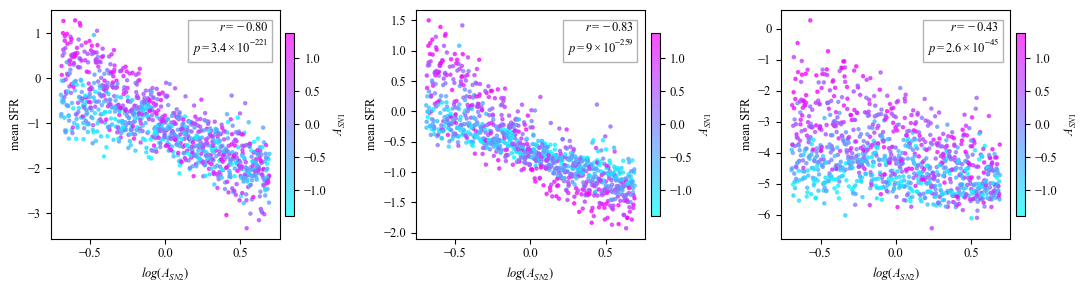

In [269]:
plotCB(4, np.log(mean_SFR), np.log(mean_SFR_spi), np.log(mean_SFR_ell), label_table[:,2], label_table[:,2], label_table[:,2], 
       ylabel=f'mean SFR', clabel=r'$A_{SN1}$')

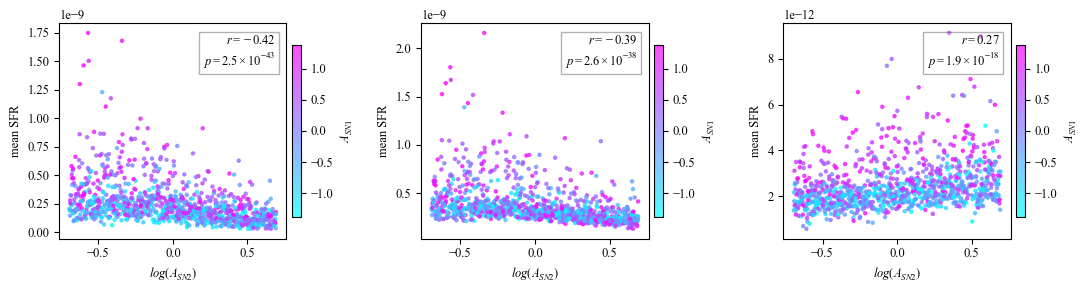

In [276]:
plotCB(4, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell, label_table[:,2], label_table[:,2], label_table[:,2], 
       ylabel=f'mean SFR', clabel=r'$A_{SN1}$')

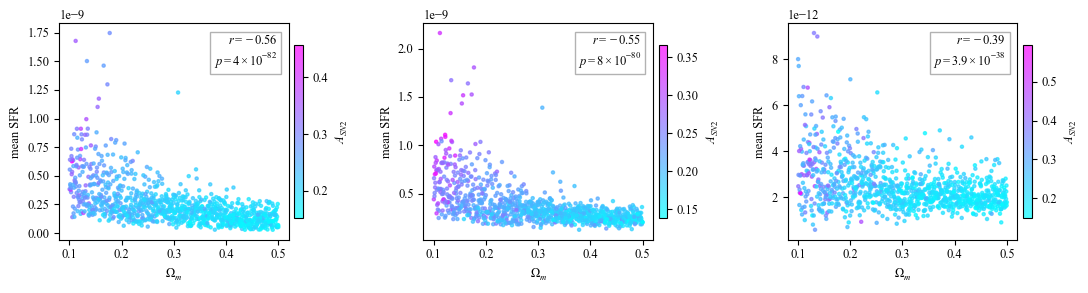

In [104]:
plotCB(0, mean_SSFR, mean_SSFR_spi, mean_SSFR_ell, mean_e, mean_e_spi, mean_e_ell, 
       ylabel=f'mean SFR', clabel=r'$A_{SN2}$')

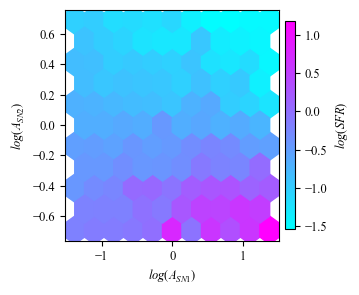

In [254]:
fig, ax = plt.subplots(figsize=(10/3, 3))
hb = ax.hexbin(
    label_table[:, 2], label_table[:, 4], 
    C=np.log(mean_SFR_spi), 
    gridsize=10,  # Adjust the resolution of the bins
    cmap=mpl.cm.cool, 
    reduce_C_function=np.mean  # Aggregate using the mean value of log(SFR) within each bin
)
ax.set_xlabel(f'${simpars[2]}$')
ax.set_ylabel(f'${simpars[4]}$')
cbar = fig.colorbar(hb, ax=ax, orientation='vertical', shrink=0.9, pad=0.02)
cbar.set_label('$log(SFR)$', fontsize=9)
# fig.set_constrained_layout(True)

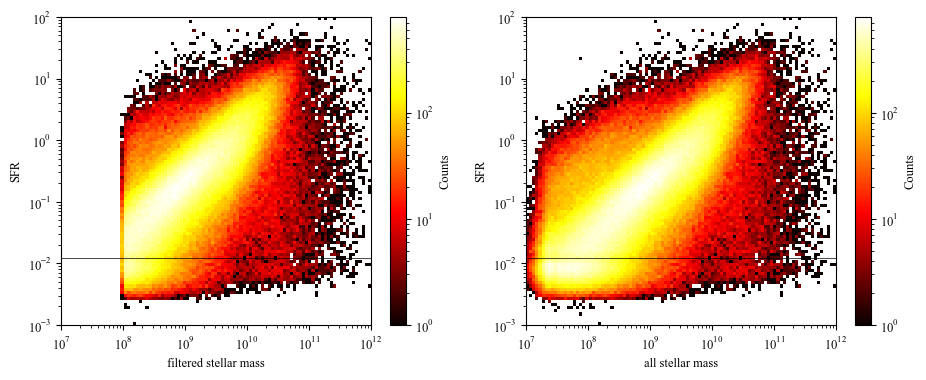

In [83]:
import matplotlib as mpl
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))
# ax[0].scatter(filt_M_R_12, filt_g_r, s=0.01)
h = ax[0].hist2d(filt_M_R_12, filt_SFR, bins=(np.logspace(7,12,100),np.logspace(-3,2,100)), norm=mpl.colors.LogNorm(), cmap='hot')
ax[0].axhline(0.012,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('SFR')
ax[0].set_xlabel('filtered stellar mass')
cbar = fig.colorbar(h[3], ax=ax[0])
cbar.set_label("Counts")

h = ax[1].hist2d(all_M_R_12, all_SFR, bins=(np.logspace(7,12,100),np.logspace(-3,2,100)), norm=mpl.colors.LogNorm(), cmap='hot')
# ax[1].scatter(all_M_R_12, all_g_r, s=0.01)
ax[1].axhline(0.012,c='k',lw=0.5)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('SFR')
ax[1].set_xlabel('all stellar mass')
cbar = fig.colorbar(h[3], ax=ax[1])
cbar.set_label("Counts")

In [28]:
SF_ = np.where(all_SFR!=0)[0]
print("Fraction of all Galaxies with SFR",len(SF_)/len(all_SFR))
NSF_ = np.where(all_SFR==0)[0]

SF = np.where(filt_SFR!=0)[0]
print("Fraction of my galaxies with SFR",len(SF)/len(filt_SFR))
NSF = np.where(filt_SFR==0)[0]
print(sum(filt_SFR<0.012)/len(filt_SFR))

Fraction of all Galaxies with SFR 0.044639033337640285
Fraction of my galaxies with SFR 0.6166339114358445
0.4274296632503305


Text(0, 0.5, 'n stars')

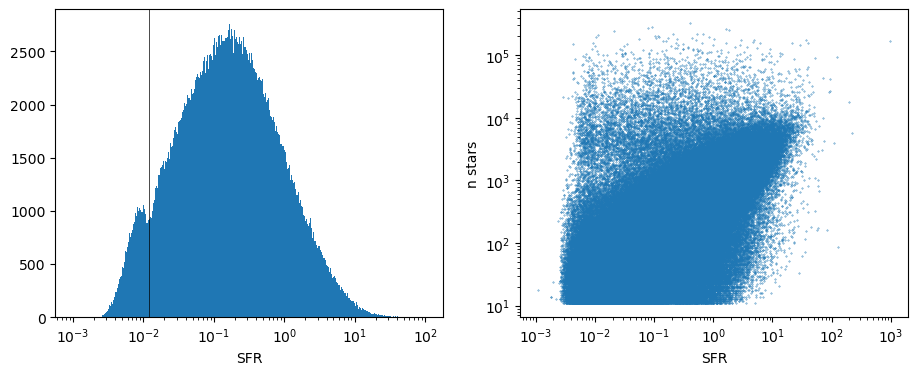

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(33/3,4))

ax[0].hist(filt_SFR[SF],bins=np.logspace(0-3,2,500))
ax[0].axvline(0.012,c='k',lw=0.5)
ax[0].set_xscale('log')
ax[0].set_xlabel('SFR')
ax[1].scatter(filt_SFR[SF], filt_nstar[SF] , s=0.1)
# plt.hist2d(all_SFR[filt] , all_M_R_12[filt],cmap='bone',bins=np.logspace(0-4,3,50))
ax[1].set_xscale('log'); ax[1].set_yscale('log')
# plt.xlim([-1,10])
plt.xlabel('SFR'); plt.ylabel('n stars')

In [78]:
print(len(filt_M_R_12), len(all_M_R_12),len(all_SFR), len(filt_M_R_12),len(all_nstar), len(filt_nstar) )

823787 16879689 16879689 823787 16879689 823787


Filter out 95.12% of subhalos. and 1 - 504388/748761 = 32.26% of subhalos with non-zero SFR

In [171]:
SF_ = np.where(all_SFR!=0)[0]
print(len(SF_)/len(all_SFR))
NSF_ = np.where(all_SFR==0)[0]

0.044639033337640285


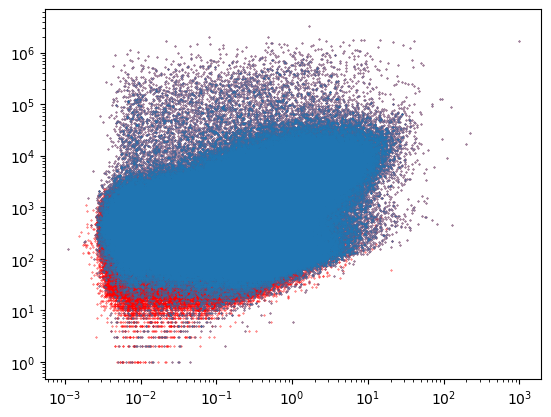

In [187]:
plt.scatter(all_SFR[SF_], all_gas[SF_] , s=0.1,c='red')
plt.scatter(filt_SFR[SF], filt_gas[SF] , s=0.1)
# plt.hist2d(all_SFR , all_gas,cmap='bone',bins=(np.logspace(1e-6,5,256),np.logspace(1e-6,2e6,256)))
plt.xscale('log'); plt.yscale('log')
# plt.xlim([-0.1,5]); plt.ylim([-1e5,2e6])

In [169]:
print(len(all_SFR),len(filt_SFR[SF]))

16879689 507975


In [3]:
# Function to convert Cartesian coordinates to spherical coordinates
def cart_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    # make it so z is parallel to line of sight of observer
    theta = np.arccos(x / r)
    phi = np.arctan2(y, z)
    return r, theta, phi

# Function to convert spherical coordinates to RA and DEC in degrees
def spherical_to_ra_dec(theta, phi):
    ra = np.degrees(phi)
    dec = 90 - np.degrees(theta)
    return ra, dec

### Making Spiral/Elliptical catalogues 

In [78]:

for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10
#     nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
#     ngas_sh = f['Subhalo/SubhaloLenType'][:,0]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LHx{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data

    pos_sh = np.array([pos_sh[:,1],pos_sh[:,2],pos_sh[:,0]]).T # Axis change
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(indices.shape[0],"=",pos_g.shape[0]," ",consistent)
    # filter out elliptical
    if consistent:

#         non_zero = SFR_sh[indices] > -10 #!=0

#         nz_pos = pos_g[non_zero]
#         nz_shape = ias[non_zero]
        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = subh_M_R_12[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        ell_pos = pos_g[elliptical]
        ell_shapes = ias[elliptical]
        
        spi_pos = pos_g[spiral]
        spi_shapes = ias[spiral]

        print(spi_shapes.shape, ell_shapes.shape)
        
        ################## SPIRALS
        
        x = spi_pos[:,0]
        y = spi_pos[:,1]
        z = spi_pos[:,2]
        ia_1 = spi_shapes[:,0]
        ia_2 = spi_shapes[:,1]


        z+= 10000

        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=ia_1),
            fits.Column(name='ia_2', format='D', array=ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_spirals/CAMELS_proj_data_LHx{filenum}.fits', overwrite=True)
        
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000

        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand),
            fits.Column(name='ia_1', format='D', array=ia_1_rand),
            fits.Column(name='ia_2', format='D', array=ia_2_rand),
        ])

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_spirals/CAMELS_proj_rand_LHx{filenum}.fits', overwrite=True)
        
        ################ ELLIPTICALS
                
        x = ell_pos[:,0]
        y = ell_pos[:,1]
        z = ell_pos[:,2]
        ia_1 = ell_shapes[:,0]
        ia_2 = ell_shapes[:,1]


        z+= 10000
        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        

        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=ia_1),
            fits.Column(name='ia_2', format='D', array=ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_ellipticals/CAMELS_proj_data_LHx{filenum}.fits', overwrite=True)
        
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000
        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand),
            fits.Column(name='ia_1', format='D', array=ia_1_rand),
            fits.Column(name='ia_2', format='D', array=ia_2_rand),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_ellipticals/CAMELS_proj_rand_LHx{filenum}.fits', overwrite=True)
        

    else:
        print('Not consistent')
        break


(290, 2) (119, 2)
(218, 2) (130, 2)
(381, 2) (789, 2)
(309, 2) (40, 2)
(284, 2) (74, 2)
(336, 2) (147, 2)
(274, 2) (243, 2)
(421, 2) (276, 2)
(464, 2) (1323, 2)
(778, 2) (740, 2)
(368, 2) (1164, 2)
(109, 2) (275, 2)
(251, 2) (370, 2)
(560, 2) (738, 2)
(297, 2) (79, 2)
(486, 2) (186, 2)
(277, 2) (120, 2)
(127, 2) (11, 2)
(213, 2) (29, 2)
(505, 2) (278, 2)
(657, 2) (480, 2)
(648, 2) (1027, 2)
(463, 2) (195, 2)
(337, 2) (148, 2)
(651, 2) (313, 2)
(285, 2) (97, 2)
(338, 2) (316, 2)
(578, 2) (280, 2)
(690, 2) (1100, 2)
(509, 2) (212, 2)
(249, 2) (103, 2)
(103, 2) (312, 2)
(526, 2) (1113, 2)
(281, 2) (76, 2)
(239, 2) (514, 2)
(584, 2) (607, 2)
(468, 2) (229, 2)
(215, 2) (294, 2)
(311, 2) (172, 2)
(213, 2) (67, 2)
(165, 2) (90, 2)
(393, 2) (1007, 2)
(349, 2) (150, 2)
(120, 2) (21, 2)
(315, 2) (71, 2)
(240, 2) (82, 2)
(380, 2) (328, 2)
(644, 2) (393, 2)
(499, 2) (798, 2)
(472, 2) (357, 2)
(641, 2) (622, 2)
(188, 2) (30, 2)
(179, 2) (99, 2)
(591, 2) (312, 2)
(681, 2) (245, 2)
(667, 2) (273, 2)


(604, 2) (174, 2)
(360, 2) (85, 2)
(399, 2) (701, 2)
(573, 2) (458, 2)
(234, 2) (152, 2)
(447, 2) (178, 2)
(251, 2) (150, 2)
(515, 2) (577, 2)
(714, 2) (175, 2)
(372, 2) (70, 2)
(355, 2) (154, 2)
(370, 2) (165, 2)
(373, 2) (1255, 2)
(624, 2) (316, 2)
(546, 2) (141, 2)
(660, 2) (717, 2)
(613, 2) (950, 2)
(568, 2) (316, 2)
(139, 2) (58, 2)
(206, 2) (109, 2)
(181, 2) (853, 2)
(642, 2) (839, 2)
(456, 2) (120, 2)
(773, 2) (305, 2)
(631, 2) (539, 2)
(825, 2) (194, 2)
(528, 2) (294, 2)
(589, 2) (203, 2)
(587, 2) (377, 2)
(663, 2) (862, 2)
(446, 2) (142, 2)
(622, 2) (603, 2)
(681, 2) (721, 2)
(446, 2) (191, 2)
(460, 2) (452, 2)
(317, 2) (36, 2)
(298, 2) (28, 2)
(235, 2) (119, 2)
(786, 2) (1124, 2)
(277, 2) (72, 2)
(318, 2) (97, 2)
(397, 2) (1384, 2)
(322, 2) (89, 2)
(323, 2) (172, 2)
(75, 2) (103, 2)
(642, 2) (641, 2)
(170, 2) (40, 2)
(217, 2) (34, 2)
(910, 2) (512, 2)
(358, 2) (181, 2)
(223, 2) (243, 2)
(387, 2) (91, 2)
(381, 2) (52, 2)
(470, 2) (188, 2)
(289, 2) (90, 2)
(363, 2) (97, 2)
(642

(622, 2) (266, 2)
(642, 2) (331, 2)
(396, 2) (41, 2)
(236, 2) (115, 2)
(410, 2) (592, 2)
(450, 2) (255, 2)
(524, 2) (500, 2)
(295, 2) (63, 2)
(729, 2) (601, 2)
(363, 2) (462, 2)
(434, 2) (240, 2)
(221, 2) (69, 2)
(592, 2) (304, 2)
(391, 2) (285, 2)
(275, 2) (141, 2)
(391, 2) (205, 2)
(709, 2) (868, 2)
(873, 2) (211, 2)
(326, 2) (166, 2)
(284, 2) (57, 2)
(497, 2) (229, 2)
(358, 2) (644, 2)
(346, 2) (105, 2)
(367, 2) (138, 2)
(834, 2) (1034, 2)
(512, 2) (144, 2)
(397, 2) (172, 2)
(767, 2) (266, 2)
(435, 2) (595, 2)
(262, 2) (64, 2)
(461, 2) (171, 2)
(314, 2) (151, 2)
(606, 2) (929, 2)
(535, 2) (508, 2)
(373, 2) (380, 2)
(205, 2) (35, 2)
(567, 2) (1485, 2)
(271, 2) (123, 2)
(486, 2) (221, 2)
(372, 2) (1164, 2)
(808, 2) (423, 2)
(531, 2) (138, 2)
(352, 2) (78, 2)
(364, 2) (117, 2)
(594, 2) (446, 2)
(296, 2) (41, 2)
(480, 2) (513, 2)
(448, 2) (155, 2)
(556, 2) (501, 2)
(409, 2) (185, 2)
(574, 2) (572, 2)
(325, 2) (74, 2)
(132, 2) (94, 2)
(339, 2) (153, 2)
(565, 2) (562, 2)
(504, 2) (188, 2)

### Making Spiral/elliptical cataloges ellipticity normalised

In [7]:
xyz = [[1,2], [2,0], [0,1]]

for filenum in range(0,1000):
    CAT = f'/Volumes/CAMELSDrive/Illustris_SUBFIND/LH{filenum}_SUBFIND.hdf5'
    # open 
    f = h5py.File(CAT, 'r')

    pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
    SFR_sh = f['Subhalo/SubhaloSFR'][:]
    subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10
#     nstar_sh = f['Subhalo/SubhaloLenType'][:,4]
#     ngas_sh = f['Subhalo/SubhaloLenType'][:,0]
    # close file
    f.close()

    fits_file_path = f'LH_ellipticities/CAMELS_data_LHy{filenum}.fits'

    with fits.open(fits_file_path) as hdul:
        data = hdul[1].data

    pos_sh = np.array([pos_sh[:,2],pos_sh[:,0],pos_sh[:,1]]).T # Axis change
    # Now you can use the same variable names
    pos_g = np.array([data['x'], data['y'], data['z']]).T
    ias = np.array([data['ia_1'], data['ia_2']]).T

    indices = np.where((pos_sh[:, None] == pos_g).all(axis=2).any(axis=1))[0]
    consistent = pos_g.shape[0]==indices.shape[0]
#     print(indices.shape[0],"=",pos_g.shape[0]," ",consistent)
    # filter out elliptical
    if consistent:

#         non_zero = SFR_sh[indices] > -10 #!=0

#         nz_pos = pos_g[non_zero]
#         nz_shape = ias[non_zero]
        SFR_g = SFR_sh[indices] #  galaxy SFR and Mass
        mass_g = subh_M_R_12[indices]

        split = 10**-10.5
        elliptical = (SFR_g/mass_g)<split
        spiral = (SFR_g/mass_g)>=split
        
        ell_pos = pos_g[elliptical]
        ell_shapes = ias[elliptical]
        
        spi_pos = pos_g[spiral]
        spi_shapes = ias[spiral]

        print(spi_shapes.shape, ell_shapes.shape)
        
        ################## SPIRALS
        
        x = spi_pos[:,0]
        y = spi_pos[:,1]
        z = spi_pos[:,2]

        
        complx_ell = spi_shapes[:,0] + 1j * spi_shapes[:,1]
        mags = np.abs(complx_ell)
        norm_ell = complx_ell / mags
        norm_ia_1 = norm_ell.real
        norm_ia_2 = norm_ell.imag


        z+= 10000

        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=norm_ia_1),
            fits.Column(name='ia_2', format='D', array=norm_ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_spirals/CAMELS_proj_data_LHy{filenum}.fits', overwrite=True)
        
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.ones((2,len(x)))#np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000

        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand),
#             fits.Column(name='ia_1', format='D', array=ia_1_rand),
#             fits.Column(name='ia_2', format='D', array=ia_2_rand),
        ])

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_spirals/CAMELS_proj_rand_LHy{filenum}.fits', overwrite=True)
        
        ################ ELLIPTICALS
                
        x = ell_pos[:,0]
        y = ell_pos[:,1]
        z = ell_pos[:,2]
        ia_1 = ell_shapes[:,0]
        ia_2 = ell_shapes[:,1]


        z+= 10000
        r, theta, phi = cart_to_spherical(x, y, z)
        ra, dec = spherical_to_ra_dec(theta, phi)
        

        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra),
            fits.Column(name='DEC', format='D', array=dec),
            fits.Column(name='r_col', format='D', array=r),
            fits.Column(name='ia_1', format='D', array=norm_ia_1),
            fits.Column(name='ia_2', format='D', array=norm_ia_2),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_ellipticals/CAMELS_proj_data_LHy{filenum}.fits', overwrite=True)
        
        x_rand, y_rand, z_rand = np.random.uniform(0, 25, (3,len(x)))
        ia_1_rand, ia_2_rand = np.random.normal(loc=0, scale=0.14, size=(2,len(x)))
        
        z_rand += 10000
        r_rand, theta, phi = cart_to_spherical(x_rand, y_rand, z_rand)
        ra_rand, dec_rand = spherical_to_ra_dec(theta, phi)
        
        # Create a FITS table
        data = fits.BinTableHDU.from_columns([
            fits.Column(name='RA', format='D', array=ra_rand),
            fits.Column(name='DEC', format='D', array=dec_rand),
            fits.Column(name='r_col', format='D', array=r_rand),
#             fits.Column(name='ia_1', format='D', array=ia_1_rand),
#             fits.Column(name='ia_2', format='D', array=ia_2_rand),
        ])

        primary_hdu = fits.PrimaryHDU()
        hdul = fits.HDUList([primary_hdu, data])

        # Save the FITS file
        hdul.writeto(f'../correlating-folder/LH_ellipticities_RADEC_noMAG_ellipticals/CAMELS_proj_rand_LHy{filenum}.fits', overwrite=True)
        

    else:
        print('Not consistent')
        break

(290, 2) (119, 2)
(218, 2) (130, 2)
(381, 2) (789, 2)
(309, 2) (40, 2)
(284, 2) (74, 2)
(336, 2) (147, 2)
(274, 2) (243, 2)
(421, 2) (276, 2)
(464, 2) (1323, 2)
(778, 2) (740, 2)
(368, 2) (1164, 2)
(109, 2) (275, 2)
(251, 2) (370, 2)
(560, 2) (738, 2)
(297, 2) (79, 2)
(486, 2) (186, 2)
(277, 2) (120, 2)
(127, 2) (11, 2)
(213, 2) (29, 2)
(505, 2) (278, 2)
(657, 2) (480, 2)
(648, 2) (1027, 2)
(463, 2) (195, 2)
(337, 2) (148, 2)
(651, 2) (313, 2)
(285, 2) (97, 2)
(338, 2) (316, 2)
(578, 2) (280, 2)
(690, 2) (1100, 2)
(509, 2) (212, 2)
(249, 2) (103, 2)
(103, 2) (312, 2)
(526, 2) (1113, 2)
(281, 2) (76, 2)
(239, 2) (514, 2)
(584, 2) (607, 2)
(468, 2) (229, 2)
(215, 2) (294, 2)
(311, 2) (172, 2)
(213, 2) (67, 2)
(165, 2) (90, 2)
(393, 2) (1007, 2)
(349, 2) (150, 2)
(120, 2) (21, 2)
(315, 2) (71, 2)
(240, 2) (82, 2)
(380, 2) (328, 2)
(644, 2) (393, 2)
(499, 2) (798, 2)
(472, 2) (357, 2)
(641, 2) (622, 2)
(188, 2) (30, 2)
(179, 2) (99, 2)
(591, 2) (312, 2)
(681, 2) (245, 2)
(667, 2) (273, 2)


(604, 2) (174, 2)
(360, 2) (85, 2)
(399, 2) (701, 2)
(573, 2) (458, 2)
(234, 2) (152, 2)
(447, 2) (178, 2)
(251, 2) (150, 2)
(515, 2) (577, 2)
(714, 2) (175, 2)
(372, 2) (70, 2)
(355, 2) (154, 2)
(370, 2) (165, 2)
(373, 2) (1255, 2)
(624, 2) (316, 2)
(546, 2) (141, 2)
(660, 2) (717, 2)
(613, 2) (950, 2)
(568, 2) (316, 2)
(139, 2) (58, 2)
(206, 2) (109, 2)
(181, 2) (853, 2)
(642, 2) (839, 2)
(456, 2) (120, 2)
(773, 2) (305, 2)
(631, 2) (539, 2)
(825, 2) (194, 2)
(528, 2) (294, 2)
(589, 2) (203, 2)
(587, 2) (377, 2)
(663, 2) (862, 2)
(446, 2) (142, 2)
(622, 2) (603, 2)
(681, 2) (721, 2)
(446, 2) (191, 2)
(460, 2) (452, 2)
(317, 2) (36, 2)
(298, 2) (28, 2)
(235, 2) (119, 2)
(786, 2) (1124, 2)
(277, 2) (72, 2)
(318, 2) (97, 2)
(397, 2) (1384, 2)
(322, 2) (89, 2)
(323, 2) (172, 2)
(75, 2) (103, 2)
(642, 2) (641, 2)
(170, 2) (40, 2)
(217, 2) (34, 2)
(910, 2) (512, 2)
(358, 2) (181, 2)
(223, 2) (243, 2)
(387, 2) (91, 2)
(381, 2) (52, 2)
(470, 2) (188, 2)
(289, 2) (90, 2)
(363, 2) (97, 2)
(642

(534, 2) (339, 2)
(622, 2) (266, 2)
(642, 2) (331, 2)
(396, 2) (41, 2)
(236, 2) (115, 2)
(410, 2) (592, 2)
(450, 2) (255, 2)
(524, 2) (500, 2)
(295, 2) (63, 2)
(729, 2) (601, 2)
(363, 2) (462, 2)
(434, 2) (240, 2)
(221, 2) (69, 2)
(592, 2) (304, 2)
(391, 2) (285, 2)
(275, 2) (141, 2)
(391, 2) (205, 2)
(709, 2) (868, 2)
(873, 2) (211, 2)
(326, 2) (166, 2)
(284, 2) (57, 2)
(497, 2) (229, 2)
(358, 2) (644, 2)
(346, 2) (105, 2)
(367, 2) (138, 2)
(834, 2) (1034, 2)
(512, 2) (144, 2)
(397, 2) (172, 2)
(767, 2) (266, 2)
(435, 2) (595, 2)
(262, 2) (64, 2)
(461, 2) (171, 2)
(314, 2) (151, 2)
(606, 2) (929, 2)
(535, 2) (508, 2)
(373, 2) (380, 2)
(205, 2) (35, 2)
(567, 2) (1485, 2)
(271, 2) (123, 2)
(486, 2) (221, 2)
(372, 2) (1164, 2)
(808, 2) (423, 2)
(531, 2) (138, 2)
(352, 2) (78, 2)
(364, 2) (117, 2)
(594, 2) (446, 2)
(296, 2) (41, 2)
(480, 2) (513, 2)
(448, 2) (155, 2)
(556, 2) (501, 2)
(409, 2) (185, 2)
(574, 2) (572, 2)
(325, 2) (74, 2)
(132, 2) (94, 2)
(339, 2) (153, 2)
(565, 2) (562, 2)